# Project Title
### Data Engineering Capstone Project

#### Project Summary
--describe your project at a high level--

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [3]:
# Do all imports and installs here
import configparser
import os
import pandas as pd
import io
import logging
import boto3
from botocore.exceptions import ClientError

from pyspark.sql import SparkSession
from pyspark.sql.functions import col,sum

from IPython.display import Image

import configparser
import psycopg2


In [4]:
config = configparser.ConfigParser()
config.read_file(open('credentials.cfg'))

os.environ["AWS_ACCESS_KEY_ID"]= config['AWS']['AWS_ACCESS_KEY_ID']
os.environ["AWS_SECRET_ACCESS_KEY"]= config['AWS']['AWS_SECRET_ACCESS_KEY']

In [5]:
IAM_role = config['CLUSTER']['DB_ROLE']

In [6]:
IAM_role

'arn:aws:iam::314840521047:role/dwhRole_p'

### Step 1: Scope the Project and Gather Data

#### Scope 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>

#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 

#### Student Comments

#### Scope 

The purpose of this project is to create a simple analytcs database to answer question related to the i94 immigation data. For example, analysts may want to know whether foreign countries' GDP and population would have significant influence on the number of immigrants entering US. 

Apart from the i94 immigration data and US City Demographics data that are ready in Workspace, the GDP and Population Data (by country by year) prepared by World Bank will also be used in this project.

There are several key steps that will be performed:
- perform EDA on i94 immigration, GDP, Population, as well as US City Demographics data
- Decide which column not to be used based on missing value %
- load data into S3 (for simulating real life situations where most of the company's data are stored in data lake such as S3)
- perform prelim ETL steps using Spark (at Workspace), and see if it would take long time to load output table into S3
- perform ETL directly using S3 and Redshift

Final output tables would include 1 fact table and 3 dimension tables (please see Data_Model.png)

#### Describe and Gather Data 

I94 Immigration Data: This data comes from the US National Tourism and Trade Office. For more information, please visit below website:
https://www.trade.gov/national-travel-and-tourism-office
    
U.S. City Demographic Data: This data comes from OpenSoft. For more information, please visit below website:
https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data
    
World Bank GDP Data. We are able to use GDP figures in specific years for particular countries. For more information, please visit below website:
https://data.worldbank.org
    
World Bank Population Data. We are able to use population figures in specific years for particular countries. For more information, please visit below website:
https://data.worldbank.org
    

In [29]:
Path_name = "..//..//data"

for folderName, subfolders, filenames in os.walk(Path_name):
    print(folderName)
    print(subfolders)

..//..//data
['18-83510-I94-Data-2016']
..//..//data/18-83510-I94-Data-2016
[]


In [30]:
Path_name = "..//..//data//18-83510-I94-Data-2016"

for folderName, subfolders, filenames in os.walk(Path_name):
    print(filenames) 

['i94_apr16_sub.sas7bdat', 'i94_sep16_sub.sas7bdat', 'i94_nov16_sub.sas7bdat', 'i94_mar16_sub.sas7bdat', 'i94_jun16_sub.sas7bdat', 'i94_aug16_sub.sas7bdat', 'i94_may16_sub.sas7bdat', 'i94_jan16_sub.sas7bdat', 'i94_oct16_sub.sas7bdat', 'i94_jul16_sub.sas7bdat', 'i94_feb16_sub.sas7bdat', 'i94_dec16_sub.sas7bdat']


In [3]:
# Read in the data here
df =pd.read_csv("immigration_data_sample.csv")

In [4]:
df.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,...,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,...,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


In [5]:
df.columns

Index(['Unnamed: 0', 'cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port',
       'arrdate', 'i94mode', 'i94addr', 'depdate', 'i94bir', 'i94visa',
       'count', 'dtadfile', 'visapost', 'occup', 'entdepa', 'entdepd',
       'entdepu', 'matflag', 'biryear', 'dtaddto', 'gender', 'insnum',
       'airline', 'admnum', 'fltno', 'visatype'],
      dtype='object')

In [5]:
df_sas = pd.read_sas("../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat")

In [17]:
df_sas.count()

cicid       3096313
i94yr       3096313
i94mon      3096313
i94cit      3096313
i94res      3096313
i94port     3096313
arrdate     3096313
i94mode     3096074
i94addr     2943941
depdate     2953856
i94bir      3095511
i94visa     3096313
count       3096313
dtadfile    3096312
visapost    1215063
occup          8126
entdepa     3096075
entdepd     2957884
entdepu         392
matflag     2957884
biryear     3095511
dtaddto     3095836
gender      2682044
insnum       113708
airline     3012686
admnum      3096313
fltno       3076764
visatype    3096313
dtype: int64

In [16]:
df_sas.head(10)

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,b'XXX',20573.0,NaN,NaN,NaN,...,b'U',NaN,1979.0,b'10282016',NaN,NaN,NaN,1.897628e+09,NaN,b'B2'
1,7.0,2016.0,4.0,254.0,276.0,b'ATL',20551.0,1.0,b'AL',NaN,...,b'Y',NaN,1991.0,b'D/S',b'M',NaN,NaN,3.736796e+09,b'00296',b'F1'
2,15.0,2016.0,4.0,101.0,101.0,b'WAS',20545.0,1.0,b'MI',20691.0,...,NaN,b'M',1961.0,b'09302016',b'M',NaN,b'OS',6.666432e+08,b'93',b'B2'
3,16.0,2016.0,4.0,101.0,101.0,b'NYC',20545.0,1.0,b'MA',20567.0,...,NaN,b'M',1988.0,b'09302016',NaN,NaN,b'AA',9.246846e+10,b'00199',b'B2'
4,17.0,2016.0,4.0,101.0,101.0,b'NYC',20545.0,1.0,b'MA',20567.0,...,NaN,b'M',2012.0,b'09302016',NaN,NaN,b'AA',9.246846e+10,b'00199',b'B2'
5,18.0,2016.0,4.0,101.0,101.0,b'NYC',20545.0,1.0,b'MI',20555.0,...,NaN,b'M',1959.0,b'09302016',NaN,NaN,b'AZ',9.247104e+10,b'00602',b'B1'
6,19.0,2016.0,4.0,101.0,101.0,b'NYC',20545.0,1.0,b'NJ',20558.0,...,NaN,b'M',1953.0,b'09302016',NaN,NaN,b'AZ',9.247140e+10,b'00602',b'B2'
7,20.0,2016.0,4.0,101.0,101.0,b'NYC',20545.0,1.0,b'NJ',20558.0,...,NaN,b'M',1959.0,b'09302016',NaN,NaN,b'AZ',9.247161e+10,b'00602',b'B2'
8,21.0,2016.0,4.0,101.0,101.0,b'NYC',20545.0,1.0,b'NY',20553.0,...,NaN,b'M',1970.0,b'09302016',NaN,NaN,b'AZ',9.247080e+10,b'00602',b'B2'
9,22.0,2016.0,4.0,101.0,101.0,b'NYC',20545.0,1.0,b'NY',20562.0,...,NaN,b'M',1968.0,b'09302016',NaN,NaN,b'AZ',9.247849e+10,b'00608',b'B1'


In [22]:
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.\
# config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
# .enableHiveSupport().getOrCreate()

# df_spark =spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')

## EDA on I94 dataset 

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,sum

spark = SparkSession \
        .builder \
        .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0") \
        .getOrCreate()

In [2]:
spark.version

'2.4.3'

In [6]:
from platform import python_version
print(python_version())

3.6.3


In [4]:
#write to parquet
# df_spark.write.parquet("sas_data")
df_spark=spark.read.parquet("sas_data")

In [5]:
df_spark.count()

3096313

In [6]:
df_spark.select(df_spark.columns[0:10]).limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate
0,5748517.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,CA,20582.0
1,5748518.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,NV,20591.0
2,5748519.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20582.0
3,5748520.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0
4,5748521.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0


In [9]:
df_spark.select(df_spark.columns[10:20]).limit(5).toPandas()

,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag
0,40.0,1.0,1.0,20160430,SYD,None,G,O,None,M
1,32.0,1.0,1.0,20160430,SYD,None,G,O,None,M
2,29.0,1.0,1.0,20160430,SYD,None,G,O,None,M
3,29.0,1.0,1.0,20160430,SYD,None,G,O,None,M
4,28.0,1.0,1.0,20160430,SYD,None,G,O,None,M


In [10]:
df_spark.select(df_spark.columns[20:30]).limit(5).toPandas()

,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,1976.0,10292016,F,None,QF,9.495387e+10,00011,B1
1,1984.0,10292016,F,None,VA,9.495562e+10,00007,B1
2,1987.0,10292016,M,None,DL,9.495641e+10,00040,B1
3,1987.0,10292016,F,None,DL,9.495645e+10,00040,B1
4,1988.0,10292016,M,None,DL,9.495639e+10,00040,B1


In [9]:
# check all column names in the I94 dataset 

df_spark.columns

['cicid',
 'i94yr',
 'i94mon',
 'i94cit',
 'i94res',
 'i94port',
 'arrdate',
 'i94mode',
 'i94addr',
 'depdate',
 'i94bir',
 'i94visa',
 'count',
 'dtadfile',
 'visapost',
 'occup',
 'entdepa',
 'entdepd',
 'entdepu',
 'matflag',
 'biryear',
 'dtaddto',
 'gender',
 'insnum',
 'airline',
 'admnum',
 'fltno',
 'visatype']

In [14]:
len(df_spark.columns)

28

In [5]:
# check origin city 

df_spark.select('i94cit').distinct().orderBy('i94cit').toPandas()

,i94cit
0,101.0
1,102.0
2,103.0
3,104.0
4,105.0
5,107.0
6,108.0
7,109.0
8,110.0
9,111.0


In [5]:
# check country of residence

df_spark.select('i94res').distinct().orderBy('i94res').toPandas()

,i94res
0,101.0
1,102.0
2,103.0
3,104.0
4,105.0
5,107.0
6,108.0
7,109.0
8,110.0
9,111.0


In [6]:
df_spark.select('i94res').distinct().orderBy('i94res').toPandas().to_csv("i94cit.csv")

In [23]:
# check State of arrival
df_spark.select('i94addr').distinct().orderBy('i94addr').toPandas()

,i94addr
0,None
1,..
2,.C
3,.D
4,.I
5,.L
6,.M
7,.N
8,.T
9,0


In [12]:
# check unique values of i94yr

df_spark.select('i94yr').distinct().orderBy('i94yr').toPandas() 

,i94yr
0,2016.0


In [13]:
df_spark.select('i94mon').distinct().orderBy('i94mon').toPandas() 

,i94mon
0,4.0


In [15]:
# check unique values of visatype

df_spark.select('visatype').distinct().orderBy('visatype').toPandas()

,visatype
0,B1
1,B2
2,CP
3,CPL
4,E1
5,E2
6,F1
7,F2
8,GMB
9,GMT


In [7]:
# check unique values of visport column

df_spark.select('visapost').distinct().orderBy('visapost').toPandas()

,visapost
0,None
1,999
2,ABD
3,ABG
4,ABJ
5,ABS
6,ABU
7,ACC
8,ACK
9,ADA


In [8]:
# check unique values of I94PORT
# df_spark.select('I94PORT').distinct().show()

df_spark.select('I94PORT').distinct().orderBy('I94PORT').toPandas()

,I94PORT
0,5KE
1,5T6
2,ABG
3,ABQ
4,ABS
5,ADS
6,ADT
7,ADW
8,AGA
9,AGN


In [6]:
df_spark.select('I94PORT').distinct().orderBy('I94PORT').toPandas().to_csv("i94port.csv")

In [6]:
s3_location = "s3a://chon-de-capstone/"
location = s3_location + "sas_data"
print(location)

df2_spark=spark.read.parquet(location)

s3a://chon-de-capstone/sas_data


In [7]:
df2_spark.count()
df2_spark.limit(20).toPandas()

1981440

In [8]:
df2_spark.limit(20).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,1817663.0,2016.0,4.0,148.0,131.0,SFR,20554.0,1.0,CA,20560.0,...,None,M,1993.0,07082016,F,None,LX,5.596042e+10,00038,WT
1,1817664.0,2016.0,4.0,148.0,131.0,SFR,20554.0,1.0,CA,20561.0,...,None,M,1987.0,07082016,M,None,LX,5.596034e+10,00038,WB
2,1817665.0,2016.0,4.0,148.0,131.0,SFR,20554.0,1.0,CA,20563.0,...,None,M,1969.0,07082016,M,None,LX,5.596041e+10,00038,WB
3,1817666.0,2016.0,4.0,148.0,131.0,SFR,20554.0,1.0,CA,20571.0,...,None,M,1979.0,07082016,F,None,LX,5.596069e+10,00038,WT
4,1817667.0,2016.0,4.0,148.0,131.0,SFR,20554.0,1.0,CA,20573.0,...,None,M,1975.0,07082016,M,None,LX,5.596102e+10,00038,WT
5,1817668.0,2016.0,4.0,148.0,131.0,SFR,20554.0,1.0,CA,20573.0,...,None,M,1979.0,07082016,F,None,LX,5.596094e+10,00038,WT
6,1817669.0,2016.0,4.0,148.0,131.0,SFR,20554.0,1.0,CA,20555.0,...,None,M,1963.0,07082016,None,None,BA,5.595920e+10,00287,WB
7,1817670.0,2016.0,4.0,148.0,131.0,SFR,20554.0,1.0,CA,20557.0,...,None,M,1974.0,07082016,None,None,LX,5.595741e+10,00038,WB
8,1817671.0,2016.0,4.0,148.0,131.0,SFR,20554.0,1.0,CA,20565.0,...,None,M,1964.0,07082016,None,None,KL,5.593042e+10,00605,WB
9,1817672.0,2016.0,4.0,148.0,131.0,SFR,20554.0,1.0,CA,20573.0,...,None,M,1976.0,07082016,None,None,BA,5.595929e+10,00287,WB


## EDA on US Cities Demographics dataset 

In [7]:
df_demo = pd.read_csv("us-cities-demographics.csv", delimiter=";")

In [8]:
df_demo.count()

City                      2891
State                     2891
Median Age                2891
Male Population           2888
Female Population         2888
Total Population          2891
Number of Veterans        2878
Foreign-born              2878
Average Household Size    2875
State Code                2891
Race                      2891
Count                     2891
dtype: int64

In [24]:
df_demo.head(10)

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402
5,Peoria,Illinois,33.1,56229.0,62432.0,118661,6634.0,7517.0,2.40,IL,American Indian and Alaska Native,1343
6,Avondale,Arizona,29.1,38712.0,41971.0,80683,4815.0,8355.0,3.18,AZ,Black or African-American,11592
7,West Covina,California,39.8,51629.0,56860.0,108489,3800.0,37038.0,3.56,CA,Asian,32716
8,O'Fallon,Missouri,36.0,41762.0,43270.0,85032,5783.0,3269.0,2.77,MO,Hispanic or Latino,2583
9,High Point,North Carolina,35.5,51751.0,58077.0,109828,5204.0,16315.0,2.65,NC,Asian,11060


In [15]:
np_city = df_demo['City'].unique()

In [17]:
type(np_city)

numpy.ndarray

In [18]:
df_city = pd.DataFrame(np_city, columns = ['US City'])

In [19]:
df_city.to_csv("US Cities.csv")

In [20]:
df_city.count()

US City    567
dtype: int64

In [21]:
np_state = df_demo['State Code'].unique()

In [22]:
np_state

array(['MD', 'MA', 'AL', 'CA', 'NJ', 'IL', 'AZ', 'MO', 'NC', 'PA', 'KS',
       'FL', 'TX', 'VA', 'NV', 'CO', 'MI', 'CT', 'MN', 'UT', 'AR', 'TN',
       'OK', 'WA', 'NY', 'GA', 'NE', 'KY', 'SC', 'LA', 'NM', 'IA', 'RI',
       'PR', 'DC', 'WI', 'OR', 'NH', 'ND', 'DE', 'OH', 'ID', 'IN', 'AK',
       'MS', 'HI', 'SD', 'ME', 'MT'], dtype=object)

## EDA on World Temperature dataset 

In [29]:
# the dataset was obtained from Kaggle; since the max. date in the dataset is Sep 2013, have chosen Apr 2013 after taking into account the seasonality.
# I94 data were based on Apr 2016.

df_wt = pd.read_csv("world_temperature_2013Apr.csv")

In [30]:
df_wt.head(10)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,2013-04-01,5.514,0.330,Århus,Denmark,57.05N,10.33E
1,2013-04-01,13.163,0.591,Çorlu,Turkey,40.99N,27.69E
2,2013-04-01,11.092,0.267,Çorum,Turkey,40.99N,34.08E
3,2013-04-01,5.718,0.517,Öskemen,Kazakhstan,50.63N,82.39E
4,2013-04-01,12.079,0.778,Ürümqi,China,44.20N,87.20E
5,2013-04-01,11.893,0.332,A Coruña,Spain,42.59N,8.73W
6,2013-04-01,8.374,0.199,Aachen,Germany,50.63N,6.34E
7,2013-04-01,5.514,0.330,Aalborg,Denmark,57.05N,10.33E
8,2013-04-01,28.059,0.974,Aba,Nigeria,5.63N,8.07E
9,2013-04-01,24.765,2.670,Abadan,Iran,29.74N,48.00E


df_wt.columns

In [32]:
df_wt.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                              object
Country                           object
Latitude                          object
Longitude                         object
dtype: object

## load data into S3 buckets

In [ ]:
# first simple test to see if Spark is working

song_data = "s3a://udacity-dend/song_data/A/Z/Z/TRAZZXH128F933D2BA.json"
df = spark.read.json(song_data)
df.toPandas()

In [5]:
import configparser
import os
import logging
import boto3
from botocore.exceptions import ClientError

In [6]:
config = configparser.ConfigParser()
config.read_file(open('credentials.cfg'))

os.environ["AWS_ACCESS_KEY_ID"]= config['AWS']['AWS_ACCESS_KEY_ID']
os.environ["AWS_SECRET_ACCESS_KEY"]= config['AWS']['AWS_SECRET_ACCESS_KEY']

os.environ["AWS_ACCESS_KEY_ID"]

In [19]:
# method 1
# upload immigration_data_sample.csv to S3 bucket

# s3 = boto3.client('s3')
# with open("immigration_data_sample.csv", "rb") as f:
#     s3.upload_fileobj(f, "chon-de-capstone", "immigration_data_sample.csv")

In [26]:
# method 1
# upload us-cities-demographics.csv to S3 bucket

# s3 = boto3.client('s3')
# with open("us-cities-demographics.csv", "rb") as f:
#     s3.upload_fileobj(f, "chon-de-capstone", "us-cities-demographics.csv")

In [27]:
# method 1
# upload I94_SAS_Labels_Descriptions.SAS to S3 bucket

# s3 = boto3.client('s3')
# with open("I94_SAS_Labels_Descriptions.SAS", "rb") as f:
#     s3.upload_fileobj(f, "chon-de-capstone", "I94_SAS_Labels_Descriptions.SAS")

In [31]:
# method 1
# upload credentials.cfg to S3 bucket

# s3 = boto3.client('s3')
# with open("credentials.cfg", "rb") as f:
#     s3.upload_fileobj(f, "chon-de-capstone", "credentials.cfg")

In [5]:
# method 1
# upload airport-codes_csv.csv to S3 bucket

# s3 = boto3.client('s3')
# with open("airport-codes_csv.csv", "rb") as f:
#     s3.upload_fileobj(f, "chon-de-capstone", "airport-codes_csv.csv")

In [7]:
# method 2
# upload airport-codes_csv.csv to S3 bucket

s3 = boto3.client('s3')
s3.upload_file(
    "airport-codes_csv.csv", "chon-de-capstone", "airport-codes_csv.csv",
    ExtraArgs={
        'GrantRead': 'uri="http://acs.amazonaws.com/groups/global/AllUsers"'
    }
)

In [8]:
# method 2
# upload I94_SAS_Labels_Descriptions.SAS to S3 bucket

s3 = boto3.client('s3')
s3.upload_file(
    "I94_SAS_Labels_Descriptions.SAS", "chon-de-capstone", "I94_SAS_Labels_Descriptions.SAS",
    ExtraArgs={
        'GrantRead': 'uri="http://acs.amazonaws.com/groups/global/AllUsers"'
    }
)

In [20]:
# method 2
# upload us-cities-demographics.csv to S3 bucket

s3 = boto3.client('s3')
s3.upload_file(
    "us-cities-demographics.csv", "chon-de-capstone", "us-cities-demographics.csv",
    ExtraArgs={
        'GrantRead': 'uri="http://acs.amazonaws.com/groups/global/AllUsers"'
    }
)

In [21]:
# method 2
# upload immigration_data_sample.csv to S3 bucket

s3 = boto3.client('s3')
s3.upload_file(
    "immigration_data_sample.csv", "chon-de-capstone", "immigration_data_sample.csv",
    ExtraArgs={
        'GrantRead': 'uri="http://acs.amazonaws.com/groups/global/AllUsers"'
    }
)

In [31]:
import os
arr = os.listdir('./sas_data')
print(arr)

['part-00003-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet', 'part-00012-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet', '.part-00010-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet.crc', '.part-00007-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet.crc', '_SUCCESS', 'part-00007-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet', '.part-00008-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet.crc', 'part-00010-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet', 'part-00004-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet', 'part-00002-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet', 'part-00008-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet', '.part-00011-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet.crc', '.part-00004-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet.crc', '.part-00002-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet.crc', 'part-00005-b9542815-7a8d-45fc-9c6

In [30]:
pwd

'/home/workspace'

s3 = boto3.client('s3')

with open("./sas_data/part-00003-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet", "rb") as f:
    s3.upload_fileobj(f, "chon-de-capstone", "sas_data/parquet_test",
    ExtraArgs={
        'GrantRead': 'uri="http://acs.amazonaws.com/groups/global/AllUsers"'
    }
)

In [35]:

s3 = boto3.client('s3')
s3.upload_file(
    "sas_data/part-00003-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet", "chon-de-capstone", "sas_data/parquet_test",
    ExtraArgs={
        'GrantRead': 'uri="http://acs.amazonaws.com/groups/global/AllUsers"'
    }
)

In [8]:
import os
arr = os.listdir('./sas_data')
for item in arr:
    print(item)

part-00003-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet
part-00012-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet
.part-00010-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet.crc
.part-00007-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet.crc
_SUCCESS
part-00007-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet
.part-00008-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet.crc
part-00010-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet
part-00004-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet
part-00002-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet
part-00008-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet
.part-00011-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet.crc
.part-00004-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet.crc
.part-00002-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet.crc
part-00005-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet
.part-000

In [ ]:
'folder/{}'.format(filename)

In [13]:
excl1 = "ipynb_"
excl2 = "crc"

for item in arr:
#     if item.index("ipynb_"):
    if excl1 in item:
        pass
#     elif item.index("crc"):
    elif excl2 in item:
        pass
    else:
        s3 = boto3.client('s3')
        s3.upload_file(
        "sas_data/{}".format(item), "chon-de-capstone", "sas_data/{}".format(item),
        ExtraArgs={
            'GrantRead': 'uri="http://acs.amazonaws.com/groups/global/AllUsers"'
            }
        )

## read data from S3

In [ ]:
# check items that stored in S3 buckets

In [26]:
import boto3

s3 = boto3.resource('s3',
                       region_name="us-west-2",
                       aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
                       aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"]
                     )

sampleDbBucket =  s3.Bucket("chon-de-capstone")

for obj in sampleDbBucket.objects.filter(Prefix=""):
    print(obj)

s3.ObjectSummary(bucket_name='chon-de-capstone', key='I94_SAS_Labels_Descriptions.SAS')
s3.ObjectSummary(bucket_name='chon-de-capstone', key='airport-codes_csv.csv')
s3.ObjectSummary(bucket_name='chon-de-capstone', key='i94cit_i94res_lookup.csv')
s3.ObjectSummary(bucket_name='chon-de-capstone', key='i94port_lookup.csv')
s3.ObjectSummary(bucket_name='chon-de-capstone', key='immigration_data_sample.csv')
s3.ObjectSummary(bucket_name='chon-de-capstone', key='sas_data/_SUCCESS')
s3.ObjectSummary(bucket_name='chon-de-capstone', key='sas_data/part-00000-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet')
s3.ObjectSummary(bucket_name='chon-de-capstone', key='sas_data/part-00001-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet')
s3.ObjectSummary(bucket_name='chon-de-capstone', key='sas_data/part-00002-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet')
s3.ObjectSummary(bucket_name='chon-de-capstone', key='sas_data/part-00003-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snapp

In [ ]:
# read I94 data from S3

In [7]:
s3_location = "s3a://chon-de-capstone/"
location = s3_location + "sas_data"
print(location)

df2_spark=spark.read.parquet(location)

s3a://chon-de-capstone/sas_data


In [7]:
df2_spark.count()

3096313

In [57]:
df2_spark.limit(10).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,5748517.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,CA,20582.0,...,None,M,1976.0,10292016,F,None,QF,9.495387e+10,00011,B1
1,5748518.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,NV,20591.0,...,None,M,1984.0,10292016,F,None,VA,9.495562e+10,00007,B1
2,5748519.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20582.0,...,None,M,1987.0,10292016,M,None,DL,9.495641e+10,00040,B1
3,5748520.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,...,None,M,1987.0,10292016,F,None,DL,9.495645e+10,00040,B1
4,5748521.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,...,None,M,1988.0,10292016,M,None,DL,9.495639e+10,00040,B1
5,5748522.0,2016.0,4.0,245.0,464.0,HHW,20574.0,1.0,HI,20579.0,...,None,M,1959.0,10292016,M,None,NZ,9.498180e+10,00010,B2
6,5748523.0,2016.0,4.0,245.0,464.0,HHW,20574.0,1.0,HI,20586.0,...,None,M,1950.0,10292016,F,None,NZ,9.497969e+10,00010,B2
7,5748524.0,2016.0,4.0,245.0,464.0,HHW,20574.0,1.0,HI,20586.0,...,None,M,1975.0,10292016,F,None,NZ,9.497975e+10,00010,B2
8,5748525.0,2016.0,4.0,245.0,464.0,HOU,20574.0,1.0,FL,20581.0,...,None,M,1989.0,10292016,M,None,NZ,9.497325e+10,00028,B2
9,5748526.0,2016.0,4.0,245.0,464.0,LOS,20574.0,1.0,CA,20581.0,...,None,M,1990.0,10292016,F,None,NZ,9.501355e+10,00002,B2


In [ ]:
# read csv data from S3 bucket

In [16]:
import pandas as pd
import boto3
import io

s3_file_key = 'airport-codes_csv.csv'
bucket = 'chon-de-capstone'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=s3_file_key)
df_air = pd.read_csv(io.BytesIO(obj['Body'].read()))

In [31]:
df_air.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [ ]:
# read US cities demographics data

In [20]:
s3_file_key = 'us-cities-demographics.csv'
bucket = 'chon-de-capstone'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=s3_file_key)
df_city = pd.read_csv(io.BytesIO(obj['Body'].read()), delimiter=";")

In [56]:
df_city.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [ ]:
# world GDP data

In [15]:
s3_file_key = 'world_GDP.txt'
bucket = 'chon-de-capstone'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=s3_file_key)
df_world = pd.read_csv(io.BytesIO(obj['Body'].read()), sep='\t', encoding='latin-1')

In [16]:
df_world.head()

,Country Lookup Key,Country Name,Country Code,GDP in USD 2010,GDP in USD 2011,GDP in USD 2012,GDP in USD 2013,GDP in USD 2014,GDP in USD 2015,GDP in USD 2016
0,ARUBA,Aruba,ABW,"2,390,502,793","2,549,720,670","2,534,636,872","2,701,675,978","2,765,363,128","2,919,553,073","2,965,921,788"
1,AFGHANISTAN,Afghanistan,AFG,"15,856,574,731","17,804,292,964","20,001,598,506","20,561,069,558","20,484,885,120","19,907,111,419","18,017,749,074"
2,ANGOLA,Angola,AGO,"83,799,496,611","111,789,686,464","128,052,853,643","136,709,862,831","145,712,200,313","116,193,649,124","101,123,851,090"
3,ALBANIA,Albania,ALB,"11,926,928,506","12,890,765,324","12,319,830,252","12,776,217,195","13,228,144,008","11,386,846,319","11,861,200,797"
4,ANDORRA,Andorra,AND,"3,449,966,857","3,629,203,786","3,188,808,943","3,193,704,343","3,271,808,157","2,789,870,188","2,896,679,212"


In [17]:
df_world['Country Name'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Albania', 'Andorra',
       'Arab World', 'United Arab Emirates', 'Argentina', 'Armenia',
       'American Samoa', 'Antigua and Barbuda', 'Australia', 'Austria',
       'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso',
       'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas, The',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda', 'Bolivia',
       'Brazil', 'Barbados', 'Brunei Darussalam', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada',
       'Central Europe and the Baltics', 'Switzerland', 'Channel Islands',
       'Chile', 'China', "Cote d'Ivoire", 'Cameroon', 'Congo, Dem. Rep.',
       'Congo, Rep.', 'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica',
       'Caribbean small states', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria',
       'East Asia & Pacific (excluding high income)',
       '

In [ ]:
# world Population data

In [39]:
s3_file_key = 'world_population.csv'
bucket = 'chon-de-capstone'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=s3_file_key)
df_population = pd.read_csv(io.BytesIO(obj['Body'].read()), encoding='latin-1', )

In [40]:
df_population.head()

,Country Lookup Key,Country Name,Country Code,Population 2010,Population 2011,Population 2012,Population 2013,Population 2014,Population 2015,Population 2016
0,ARUBA,Aruba,ABW,101669.0,102046.0,102560.0,103159.0,103774.0,104341.0,104872.0
1,AFGHANISTAN,Afghanistan,AFG,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0
2,ANGOLA,Angola,AGO,23356246.0,24220661.0,25107931.0,26015780.0,26941779.0,27884381.0,28842484.0
3,ALBANIA,Albania,ALB,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0
4,ANDORRA,Andorra,AND,84449.0,83747.0,82427.0,80774.0,79213.0,78011.0,77297.0


In [12]:
df_population['Country Name'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Albania', 'Andorra',
       'Arab World', 'United Arab Emirates', 'Argentina', 'Armenia',
       'American Samoa', 'Antigua and Barbuda', 'Australia', 'Austria',
       'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso',
       'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas, The',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda', 'Bolivia',
       'Brazil', 'Barbados', 'Brunei Darussalam', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada',
       'Central Europe and the Baltics', 'Switzerland', 'Channel Islands',
       'Chile', 'China', "Cote d'Ivoire", 'Cameroon', 'Congo, Dem. Rep.',
       'Congo, Rep.', 'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica',
       'Caribbean small states', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria',
       'East Asia & Pacific (excluding high income)',
       '

In [ ]:
# i94cit_i94res_lookup table

In [21]:
s3_file_key = 'i94cit_i94res_lookup.csv'
bucket = 'chon-de-capstone'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=s3_file_key)
df_i94cit_res = pd.read_csv(io.BytesIO(obj['Body'].read()), encoding='latin-1', )

In [23]:
df_i94cit_res.head()

,Code,Country
0,582,MEXICO
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA


In [24]:
# i94port_lookup table

s3_file_key = 'i94port_lookup.csv'
bucket = 'chon-de-capstone'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=s3_file_key)
df_i94port = pd.read_csv(io.BytesIO(obj['Body'].read()), encoding='latin-1', )

In [25]:
df_i94port.head()

,I94port,Country Key,State
0,ALC,ALCAN,AK
1,ANC,ANCHORAGE,AK
2,BAR,BAKERAAF-BAKERISLAND,AK
3,DAC,DALTONSCACHE,AK
4,PIZ,DEWSTATIONPTLAYDEW,AK


In [12]:
# volume check for i94 loaded from S3

df2_spark.count()

3096313

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

#### Student comments

4 columns in I94 immigration data has % of missing value > 50%, which include visapost, occup, entdepu, & insnum. 
These 4 columns will be dropped from this project.

Missing values in the other tables are limited, and suggest to leave the nulls as they are in the ETL process.

Also, two lookup tables have been created:
- one for US city lookup (e.g. i94port) against US Cities Demographics data.
- the other for world country lookup (e.g. i94cit & i94res) against world GDP as well as world population data.


In [18]:
# Performing cleaning tasks here


# function to calculate number of missing values in Pandas dataframe
def check_missing_values_by_Column(df):
    df_null = pd.DataFrame(data= df.isnull().sum(), columns=['count of missing values'])
    df_null["Missing %"] = ( ( df_null['count of missing values']/df.count() ) * 100 ).apply(lambda x:round(x,1))
    
    return df_null


from pyspark.sql.functions import col,sum
def check_missing_values_by_Column_Pandas(df):
    df_null = df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).toPandas().transpose()
    df_null.columns = ['count of missing values']
    df_null["Missing %"] = ( ( df_null['count of missing values']/df.count() ) * 100 ).apply(lambda x:round(x,1))
    
    return df_null

In [33]:
# check missing values in I94 immigration data

check_missing_values_by_Column_Pandas(df2_spark)

,count of missing values,Missing %
cicid,0,0.0
i94yr,0,0.0
i94mon,0,0.0
i94cit,0,0.0
i94res,0,0.0
i94port,0,0.0
arrdate,0,0.0
i94mode,239,0.0
i94addr,152592,4.9
depdate,142457,4.6


In [34]:
# check missing values in World GDP

check_missing_values_by_Column(df_world)

,count of missing values,Missing %
Country Lookup Key,0,0.0
Country Name,0,0.0
Country Code,0,0.0
GDP in USD 2010,12,4.8
GDP in USD 2011,10,3.9
GDP in USD 2012,11,4.3
GDP in USD 2013,11,4.3
GDP in USD 2014,11,4.3
GDP in USD 2015,12,4.8
GDP in USD 2016,13,5.2


In [19]:
# check missing values of world population

check_missing_values_by_Column(df_population)

,count of missing values,Missing %
Country Lookup Key,0,0.0
Country Name,0,0.0
Country Code,0,0.0
Population 2010,1,0.4
Population 2011,1,0.4
Population 2012,2,0.8
Population 2013,2,0.8
Population 2014,2,0.8
Population 2015,2,0.8
Population 2016,2,0.8


In [21]:
# check missing values of US Cities Demographics

check_missing_values_by_Column(df_city)

,count of missing values,Missing %
City,0,0.0
State,0,0.0
Median Age,0,0.0
Male Population,3,0.1
Female Population,3,0.1
Total Population,0,0.0
Number of Veterans,13,0.5
Foreign-born,13,0.5
Average Household Size,16,0.6
State Code,0,0.0


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

#### Student comments

3.1 Conceptual Data Model

Here we are trying to build a pipeline or simple data warehouse that would allow us to do analytics on immigration data; in the case, analysts would be interested in (but not limited to) the following questions:
- did the demographic composition of a city in US have any influence on immigrants' decision in terms of where to travel?
- did GDP or GDP growth in the past years of a particular country have any impact on the number of travellers generated from that country?
- did population or population growth in the past years of a particular country have any impact on the number of travellers generated from that country?

As we can see from below graph, the fact table of the data model comes from I94 immigration data. 

Here we have 3 dimension tables for slicing and dicing the fact table, which includes US City Demographics, GDP by country, as well as population by country.

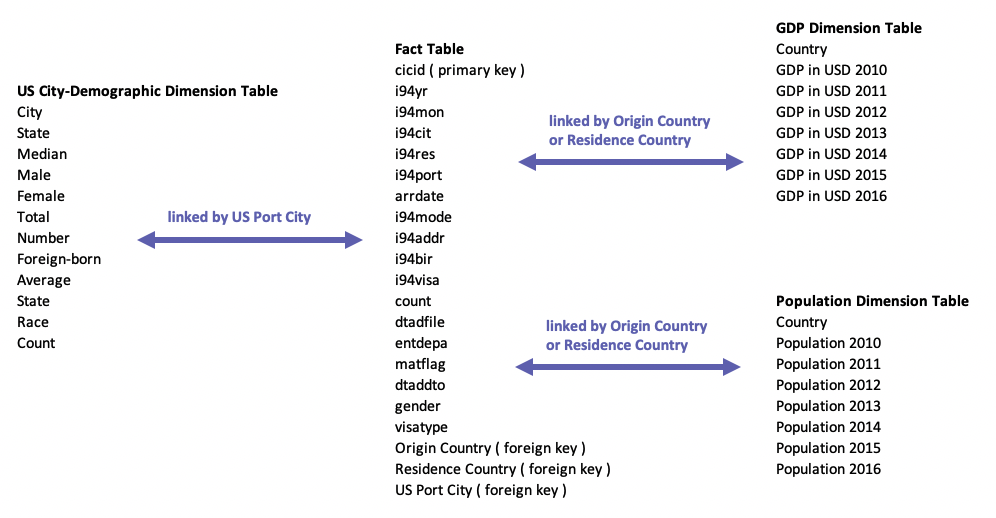

In [12]:
Image(filename="Data_Model.png", width=850, height=500)

In [13]:
# Below two methods can also be used to import png into Notebook:

Method 1:
![title](xxxxxxx.png)

Method 2:
from IPython.display import Image \
Image(filename="data_model.png", width=500, height=350)

3.2 Mapping Out Data Pipelines

Here we are simulatiing a real life situation where data would normally stored in S3. So we first upload all relevant raw data into S3 first (and this step is not a part of our data pipline):
- load I94 immigration data (parquet format) into S3
- download World GDP by country data from world bank (https://data.worldbank.org/), and upload it to S3 as world_GDP.txt (tab delimited)
- download world population by country data from world bank (https://data.worldbank.org/), and upload it to S3 as world_population.csv
- create a lookup table for i94port, and upload it into S3, which will be used for creating the "US Port City" foreign key in Fact Table for US Cities Demographics Dimension Table
- create a lookup table for i94cit/i94res, and upload it into S3, which can be used for creating the "Origin Country" and "Residence Country" foreign key in Fact Table for GDP and Population Dimension Table


Data pipeline steps are as follows:
- load the i94 immigration raw data from S3 into AWS Redshift
- load the i94port lookup table from S3 into AWS Redshift
- load the i94cit/i94res lookup table from S3 into AWS Redshift 
- create the fact table in AWS Redshift by combining the above 3 tables (i.e. with i94 immigration raw data left joining the two lookup tables)
- load data for the 3 Dimension Tables (see Data_Model.png) from s3 into AWS Redshift


### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [ ]:
# Write code here

### Prelim trial using Spark

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,sum

spark = SparkSession \
        .builder \
        .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0") \
        .getOrCreate()

In [29]:
spark.version

'2.4.3'

In [16]:
# create stage_fact table (from i94 immigration data) in Spark
Stage_fact=spark.read.parquet("s3a://chon-de-capstone/sas_data")

In [17]:
Stage_fact.limit(6).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,5748517.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,CA,20582.0,...,None,M,1976.0,10292016,F,None,QF,9.495387e+10,00011,B1
1,5748518.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,NV,20591.0,...,None,M,1984.0,10292016,F,None,VA,9.495562e+10,00007,B1
2,5748519.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20582.0,...,None,M,1987.0,10292016,M,None,DL,9.495641e+10,00040,B1
3,5748520.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,...,None,M,1987.0,10292016,F,None,DL,9.495645e+10,00040,B1
4,5748521.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,...,None,M,1988.0,10292016,M,None,DL,9.495639e+10,00040,B1
5,5748522.0,2016.0,4.0,245.0,464.0,HHW,20574.0,1.0,HI,20579.0,...,None,M,1959.0,10292016,M,None,NZ,9.498180e+10,00010,B2


In [29]:
# create i94port_lookup table in Spark
i94port_lookup = spark.read.load("s3a://chon-de-capstone/i94port_lookup_v2.csv", format="csv", sep=",", inferSchema="true", header="true")

In [30]:
i94port_lookup.limit(6).toPandas()

,Code,City I94,State
0,ALC,ALCAN,AK
1,ANC,ANCHORAGE,AK
2,BAR,BAKERAAF-BAKERISLAND,AK
3,DAC,DALTONSCACHE,AK
4,PIZ,DEWSTATIONPTLAYDEW,AK
5,DTH,DUTCHHARBOR,AK


In [20]:
# create i94cit_i94res_lookup table in Spark
i94cit_res_lookup = spark.read.load("s3a://chon-de-capstone/i94cit_i94res_lookup.csv", format="csv", sep=",", inferSchema="true", header="true")

In [21]:
i94cit_res_lookup.limit(6).toPandas()

,Code,Country
0,582,MEXICO
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA
5,324,ANGOLA


In [22]:
Stage_fact.createOrReplaceTempView('Stage_fact_view')
i94port_lookup.createOrReplaceTempView('i94port_lookup_view')
i94cit_res_lookup.createOrReplaceTempView('i94cit_res_lookup_view')

In [33]:
Staging_fact_table = spark.sql('''
    select a.*, b.`City I94` as US_Port_City, c.Country as Origin_Country, d.Country as Residence_Country
    from Stage_fact_view a 
    left join i94port_lookup_view b on (a.I94port = b.Code)
    left join i94cit_res_lookup_view c on (a.i94cit = c.Code)
    left join i94cit_res_lookup_view d on (a.i94res = d.Code)
    '''
    )

In [34]:
Staging_fact_table.limit(10).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,dtaddto,gender,insnum,airline,admnum,fltno,visatype,US_Port_City,Origin_Country,Residence_Country
0,5748517.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,CA,20582.0,...,10292016,F,None,QF,9.495387e+10,00011,B1,LOSANGELES,CHINA,AUSTRALIA
1,5748518.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,NV,20591.0,...,10292016,F,None,VA,9.495562e+10,00007,B1,LOSANGELES,CHINA,AUSTRALIA
2,5748519.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20582.0,...,10292016,M,None,DL,9.495641e+10,00040,B1,LOSANGELES,CHINA,AUSTRALIA
3,5748520.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,...,10292016,F,None,DL,9.495645e+10,00040,B1,LOSANGELES,CHINA,AUSTRALIA
4,5748521.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,...,10292016,M,None,DL,9.495639e+10,00040,B1,LOSANGELES,CHINA,AUSTRALIA
5,5748522.0,2016.0,4.0,245.0,464.0,HHW,20574.0,1.0,HI,20579.0,...,10292016,M,None,NZ,9.498180e+10,00010,B2,HONOLULU,CHINA,NEW ZEALAND
6,5748523.0,2016.0,4.0,245.0,464.0,HHW,20574.0,1.0,HI,20586.0,...,10292016,F,None,NZ,9.497969e+10,00010,B2,HONOLULU,CHINA,NEW ZEALAND
7,5748524.0,2016.0,4.0,245.0,464.0,HHW,20574.0,1.0,HI,20586.0,...,10292016,F,None,NZ,9.497975e+10,00010,B2,HONOLULU,CHINA,NEW ZEALAND
8,5748525.0,2016.0,4.0,245.0,464.0,HOU,20574.0,1.0,FL,20581.0,...,10292016,M,None,NZ,9.497325e+10,00028,B2,HOUSTON,CHINA,NEW ZEALAND
9,5748526.0,2016.0,4.0,245.0,464.0,LOS,20574.0,1.0,CA,20581.0,...,10292016,F,None,NZ,9.501355e+10,00002,B2,LOSANGELES,CHINA,NEW ZEALAND


In [25]:
Staging_fact_table.count()

3096313

In [ ]:
output_data = "s3a://chon-de-capstone/"
Staging_fact_table.write.partitionBy('i94cit', 'i94res', 'i94port').parquet(os.path.join(output_data, 'staging/staging_fact_table.parquet'), 'overwrite')

### loading the i94 immigration fact table from spark to S3 had taken a long time; suggest to try another approach using AWS Redshift

### Load Data from S3 into Redshift

In [7]:
#connect to PostgreSQL in AWS Redshift
config = configparser.ConfigParser()
config.read_file(open('credentials.cfg'))

conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
cur = conn.cursor()

In [7]:
# check schema of i94 immigration data
df_spark.schema

StructType(List(StructField(cicid,DoubleType,true),StructField(i94yr,DoubleType,true),StructField(i94mon,DoubleType,true),StructField(i94cit,DoubleType,true),StructField(i94res,DoubleType,true),StructField(i94port,StringType,true),StructField(arrdate,DoubleType,true),StructField(i94mode,DoubleType,true),StructField(i94addr,StringType,true),StructField(depdate,DoubleType,true),StructField(i94bir,DoubleType,true),StructField(i94visa,DoubleType,true),StructField(count,DoubleType,true),StructField(dtadfile,StringType,true),StructField(visapost,StringType,true),StructField(occup,StringType,true),StructField(entdepa,StringType,true),StructField(entdepd,StringType,true),StructField(entdepu,StringType,true),StructField(matflag,StringType,true),StructField(biryear,DoubleType,true),StructField(dtaddto,StringType,true),StructField(gender,StringType,true),StructField(insnum,StringType,true),StructField(airline,StringType,true),StructField(admnum,DoubleType,true),StructField(fltno,StringType,true),

##### load Staging Fact Table into Redshift

In [6]:
staging_fact_create= ("""
CREATE TABLE IF NOT EXISTS staging_fact (
    cicid float,
    i94yr float,
    i94mon float,
    i94cit float,
    i94res float,
    i94port VARCHAR,
    arrdate float,
    i94mode float,
    i94addr VARCHAR,
    depdate float, 
    i94bir float,
    i94visa float,
    count float,
    dtadfile VARCHAR,
    visapost VARCHAR,
    occup  VARCHAR,
    entdepa VARCHAR,
    entdepd VARCHAR,
    entdepu VARCHAR,
    matflag VARCHAR,
    biryear float,
    dtaddto VARCHAR,
    gender VARCHAR,
    insnum VARCHAR,
    airline VARCHAR,
    admnum float,
    fltno VARCHAR,
    visatype VARCHAR,
    PRIMARY KEY (cicid))
""")

In [7]:
cur.execute(staging_fact_create)
conn.commit()

In [6]:
load_staging_fact = ("""
copy {} from '{}' 
IAM_ROLE '{}'
FORMAT AS PARQUET;
""").format(
    'staging_fact',
    's3://chon-de-capstone/sas_data', 
    'arn:aws:iam::314840521047:role/dwhRole_p'
)

In [7]:
cur.execute(load_staging_fact)
conn.commit()

##### load i94port lookup table into Redshift

In [8]:
lookup_i94port_create= ("""
CREATE TABLE IF NOT EXISTS lookup_i94port (
    Code VARCHAR,
    City VARCHAR,
    State VARCHAR,
    PRIMARY KEY (Code))
""")

In [9]:
cur.execute(lookup_i94port_create)
conn.commit()

In [10]:
load_lookup_i94port = ("""
copy {} from '{}' 
IAM_ROLE '{}'
IGNOREHEADER 1
ACCEPTINVCHARS
DELIMITER ','
;
""").format(
    'lookup_i94port',
    's3://chon-de-capstone/i94port_lookup_v2.csv',
    'arn:aws:iam::314840521047:role/dwhRole_p'
)

In [11]:
cur.execute(load_lookup_i94port)
conn.commit()

##### load i94cit_i94res lookup table into Redshift

In [14]:
lookup_i94cit_i94res_create= ("""
CREATE TABLE IF NOT EXISTS lookup_i94cit_i94res (
    Code VARCHAR,
    Country VARCHAR,
    PRIMARY KEY (Code))
""")

In [15]:
cur.execute(lookup_i94cit_i94res_create)
conn.commit()

In [16]:
load_lookup_i94cit_i94res = ("""
copy {} from '{}' 
IAM_ROLE '{}'
IGNOREHEADER 1
ACCEPTINVCHARS
CSV QUOTE as '\"'
DELIMITER ','
;
""").format(
    'lookup_i94cit_i94res',
    's3://chon-de-capstone/i94cit_i94res_lookup.csv',
    'arn:aws:iam::314840521047:role/dwhRole_p'
)

In [17]:
cur.execute(load_lookup_i94cit_i94res)
conn.commit()

In [18]:
fact_table_create= ("""
CREATE TABLE IF NOT EXISTS fact_table (
    cicid float,
    i94yr float,
    i94mon float,
    i94cit VARCHAR,
    i94res VARCHAR,
    i94port VARCHAR,
    arrdate float,
    i94mode float,
    i94addr VARCHAR,
    i94bir float,
    i94visa float,
    count float,
    dtadfile VARCHAR,
    entdepa VARCHAR,
    matflag VARCHAR,
    dtaddto VARCHAR,
    gender VARCHAR,
    visatype VARCHAR,
    "Origin Country" VARCHAR,
    "Residence Country" VARCHAR,
    "US Port City" VARCHAR,
    PRIMARY KEY (cicid))
""")

In [19]:
cur.execute(fact_table_create)
conn.commit()

##### load data from staging_fact and lookup tables into the final fact table

In [20]:
fact_table_insert = ("""
INSERT INTO fact_table ( cicid, i94yr, i94mon, i94cit, i94res, i94port, arrdate, i94mode, i94addr, i94bir, i94visa, count, dtadfile, entdepa, matflag, dtaddto,
                         gender, visatype, "US Port City", "Origin Country", "Residence Country" ) 
SELECT  
    sf.cicid, sf.i94yr, sf.i94mon, sf.i94cit, sf.i94res, sf.i94port, sf.arrdate, sf.i94mode, sf.i94addr, sf.i94bir, sf.i94visa, sf.count, sf.dtadfile, sf.entdepa, 
    sf.matflag, sf.dtaddto, sf.gender, sf.visatype, b.City, c.Country, d.Country
FROM staging_fact sf
left join lookup_i94port b on (sf.i94port = b.Code)
left join lookup_i94cit_i94res c on (sf.i94cit = c.Code)
left join lookup_i94cit_i94res d on (sf.i94res = d.Code)
""")

In [21]:
cur.execute(fact_table_insert)
conn.commit()

##### load GDP Dimension Table into Redshift

In [22]:
GDP_table_create= ("""
CREATE TABLE IF NOT EXISTS GDP_dimension (
    Country VARCHAR,
    "GDP in USD 2010" float,
    "GDP in USD 2011" float,
    "GDP in USD 2012" float,
    "GDP in USD 2013" float,
    "GDP in USD 2014" float,
    "GDP in USD 2015" float,
    "GDP in USD 2016" float,
    PRIMARY KEY (Country))
""")

In [23]:
cur.execute(GDP_table_create)
conn.commit()

In [24]:
load_GDP_dimension = ("""
copy GDP_dimension from 's3://chon-de-capstone/world_GDP.txt' 
IAM_ROLE 'arn:aws:iam::314840521047:role/dwhRole_p'
IGNOREHEADER 1
DELIMITER '\t'
ACCEPTINVCHARS ;
""")

In [25]:
cur.execute(load_GDP_dimension)
conn.commit()

##### load Population Dimension Table into Redshift

In [26]:
Population_table_create= ("""
CREATE TABLE IF NOT EXISTS Population_dimension (
    Country VARCHAR,
    "Population 2010" float,
    "Population 2011" float,
    "Population 2012" float,
    "Population 2013" float,
    "Population 2014" float,
    "Population 2015" float,
    "Population 2016" float,
    PRIMARY KEY (Country))
""")

In [27]:
cur.execute(Population_table_create)
conn.commit()

In [28]:
load_population_dimension = ("""
copy Population_dimension from 's3://chon-de-capstone/world_population.csv' 
IAM_ROLE 'arn:aws:iam::314840521047:role/dwhRole_p'
CSV 
IGNOREHEADER 1
ACCEPTINVCHARS ;
""")

In [29]:
cur.execute(load_population_dimension)
conn.commit()

##### load US City Demographics Dimension Table into Redshift

In [73]:
demographic_dimension_create= ("""
CREATE TABLE IF NOT EXISTS US_demographic_dimension (
    City VARCHAR,
    State VARCHAR,
    "Median Age" float,
    "Male Population" float,
    "Female Population" float,
    "Total Population" float,
    "Number of Veterans" float,
    "Foreign-born" float,
    "Average Household Size" float,
    "State Code" VARCHAR,
    Race VARCHAR,
    Count float,
    PRIMARY KEY (City, State, Race))
""")

In [60]:
demographic_dimension_create= ("""
CREATE TABLE IF NOT EXISTS US_demographic_dimension (
    City VARCHAR,
    State VARCHAR,
    "Median Age" float,
    "Male Population" float,
    "Female Population" float,
    "Total Population" float,
    "Number of Veterans" float,
    "Foreign-born" float,
    "Average Household Size" float,
    "State Code" VARCHAR,
    Race VARCHAR,
    Count float,
    PRIMARY KEY (City))
""")

In [74]:
cur.execute(demographic_dimension_create)
conn.commit()

In [75]:
load_demographic_dimension = ("""
copy {} from '{}' 
IAM_ROLE '{}'
IGNOREHEADER 1
ACCEPTINVCHARS
CSV QUOTE as '\"'
DELIMITER ';'
;
""").format(
    'US_demographic_dimension',
    's3://chon-de-capstone/us-cities-demographics.csv',
    'arn:aws:iam::314840521047:role/dwhRole_p'
)

In [76]:
cur.execute(load_demographic_dimension)
conn.commit()

##### create city lookup key in US_demographic_dimension

In [77]:
demographic_dimension_add_key= ("""
ALTER TABLE US_demographic_dimension 
ADD COLUMN lookup_key VARCHAR ;
""")

In [78]:
cur.execute(demographic_dimension_add_key)
conn.commit()

In [79]:
demographic_key_update= ("""
UPDATE US_demographic_dimension
SET lookup_key = REPLACE(TRIM(UPPER(City)), ' ', '');
""")

In [80]:
cur.execute(demographic_key_update)
conn.commit()

In [81]:
demographic_dimension_drop_column= ("""
ALTER TABLE US_demographic_dimension 
DROP COLUMN City CASCADE ;
""")

In [82]:
cur.execute(demographic_dimension_drop_column)
conn.commit()

In [83]:
demographic_dimension_rename = ("""
ALTER TABLE US_demographic_dimension 
RENAME lookup_key TO City;
""")

In [84]:
cur.execute(demographic_dimension_rename)
conn.commit()

In [59]:
# run this cell if there is any error in above steps

curs = conn.cursor()
curs.execute("ROLLBACK")
conn.commit()

In [32]:
# DROP TABLE IF EXISTS Population_dimension

Drop_table_sql= ("""
DROP TABLE IF EXISTS {}
""")

In [72]:
cur.execute(Drop_table_sql.format("US_demographic_dimension"))
conn.commit()

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [ ]:
# Row count checks 

In [16]:
def check_row_count(table):
    
    select_count = ("""
        select count(*) from {} ;
    """)
    
    cur.execute(select_count.format(table))
    RowCount = cur.fetchone()
    conn.commit()
     
    if RowCount[0] < 1:
        print("No records present in {table}")
        raise ValueError(f"Data quality check failed. {table} returned no results")
    else:
        print(f"Data quality check on {table} passed with {RowCount[0]} records")

In [17]:
check_row_count("fact_table")

Data quality check on fact_table passed with 3096313 records


In [18]:
check_row_count("GDP_dimension")

Data quality check on GDP_dimension passed with 264 records


In [19]:
check_row_count("Population_dimension")

Data quality check on Population_dimension passed with 264 records


In [20]:
check_row_count("US_demographic_dimension")

Data quality check on US_demographic_dimension passed with 2891 records


In [ ]:
# check whether Unique Key contains any duplicate

In [18]:
unique_key_summary = ("""
        select max(dup_count) from
        ( select {}, count(*) as dup_count from {} 
        group by {} ) A ;
    """)

In [30]:
cur.execute(unique_key_summary.format("City", "US_demographic_dimension", "City"))
DupCount = cur.fetchone()
conn.commit()

In [31]:
DupCount

(15,)

In [25]:
def unique_key_check(table, column):
    
    unique_key_summary = ("""
        select max(dup_count) from
        ( select {}, count(*) as dup_count from {} 
        group by {} ) A ;
    """)
    
    cur.execute(unique_key_summary.format(column, table, column))
    DupCount = cur.fetchone()
    conn.commit()
     
    if DupCount[0] > 1:
        print("Unique Key has been compromised in {table}")
        raise ValueError(f"Data quality check failed. {table} has a broken unique Key")
    else:
        print(f"Unique key check on {table} passed with {DupCount[0]} record.")

In [26]:
unique_key_check("fact_table", "cicid")

Unique key check on fact_table passed with 1 record.


In [27]:
unique_key_check("GDP_dimension", "country")

Unique key check on GDP_dimension passed with 1 record.


In [28]:
unique_key_check("Population_dimension", "country")

Unique key check on Population_dimension passed with 1 record.


In [47]:
unique_key_check("US_demographic_dimension", "City, State, Race")

Unique key check on US_demographic_dimension passed with 1 record.


#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Student comments

Please see Data Dictionary.txt in the work space folder

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

#### Student comments

* Clearly state the rationale for the choice of tools and technologies for the project.

The i94 immigration data stored in workspace has around 3 millions records; once the data is in S3, it can be loaded into AWS Redshift swiftly. So the two main tools that have been used in this project are S3 and AWS Redshift.

During the EDA process, Spark has been used (directly in the workspace environment) for reading parquet files; although it is also easy to use, however, if, instead of loading data into Redshift, we write output data from Spark (in Workspace) to S3, it would take quite long time to load the i94 immigration data. 

* Propose how often the data should be updated and why.

The i94 immigration data in workspace was collected for April 2016. If new immigration data are to be released on a monthly basis, it would make sense to update the pipeline on a monthly basis too.


* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.

If data is increased by 100x, I would suggest to launch AWS EMR and use Spark in it; that would allow us to leverage the full power of distributed computing, which is something Spark really excels at.


 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 
If data needs to be updated on a daily basis, Airflow would be a great tool that allows us to monitor the pipeline without spending too much attention and energy in managing it.
    
    
 * The database needed to be accessed by 100+ people.

In this case, AWS Redshift is already a good option; IAM would be a great tool which allow us to easily control who can access what.
